# Table of Contents:
Given a patient, time periods, and certain channels, we can explore the eigenspectrum, adjacency matrix and raw iEEG data.

* Eigenspectrum and Adjacency Matrix <a href='#section1'>Link</a>
* Raw iEEG Data <a href='#section2'>Link</a>


In [1]:
import pandas as pd
import numpy as np
import json
import os
from IPython.display import display

import scipy, scipy.io


import matplotlib
from matplotlib import *
from matplotlib import pyplot as plt
import itertools
from mpl_toolkits.axes_grid1 import make_axes_locatable
# pretty charting
import seaborn as sns
sns.set_palette('muted')
sns.set_style('darkgrid')
from natsort import natsorted, ns

%matplotlib inline


## sklearn imports
import sklearn.linear_model
import sklearn.cross_validation
import sklearn.tree
import sklearn.ensemble
import sklearn.preprocessing
import sklearn.feature_selection
import sklearn.pipeline
import sklearn.grid_search

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

<a id="section1"></a>
### Section 1: Eigenspectrum and Adjacency Matrix

In [2]:
# user changes: patient, and time period
patients = ['JH104sz1']
timePeriod = [58, 60]

# paramaters of data
freq = 1000
winSize = 500
stepSize = 500

# directories
dataDir = '../data/'
adjDir = '../adj_mats_win500_step500_freq1000/'

patient = patients[0]
patientDir = adjDir + patient + '/'
matFiles = []
for file in os.listdir(patientDir):
    if file.endswith('.mat'):
        matFiles.append(file)
        
## given time period
timePeriod = np.asarray(timePeriod) * 1000 # convert to ms
timePeriod = np.linspace(timePeriod[0], timePeriod[1], num=np.ptp(timePeriod)/winSize+1)

# find files of this time period, and show their corresponding eigenspectrum and heatmap of adjacency mat
filesInPeriod = []
for file in matFiles:
    for time in timePeriod:
        if str(int(time)) in file:
            filesInPeriod.append(file)
            
print filesInPeriod

['JH104sz1_1_before60000.mat', 'JH104sz1_2_before59500.mat', 'JH104sz1_3_before59000.mat', 'JH104sz1_4_before58500.mat', 'JH104sz1_5_before58000.mat']


In [3]:
## example grab of data
for file in matFiles:
    data = scipy.io.loadmat(patientDir + file, squeeze_me=True, struct_as_record=False)
    data = data['data']
    print file
    print data.earlyspread_labels
    break

JH104sz1_100_before10500.mat
[u'POLLPF5' u'POLLPF6' u'POLLFP2' u'POLLFP3' u'POLLFP4']


## Analyze Certain Time Period

Analyzes a certain time period input by the user in cell above to show the eigenspectrum, adjacency matrix and also the perturbation necessary to move system into instability.

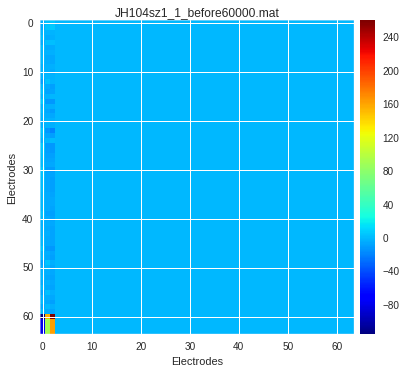

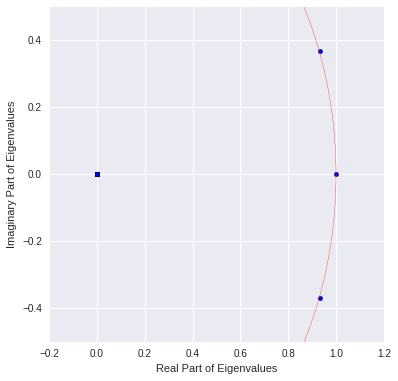

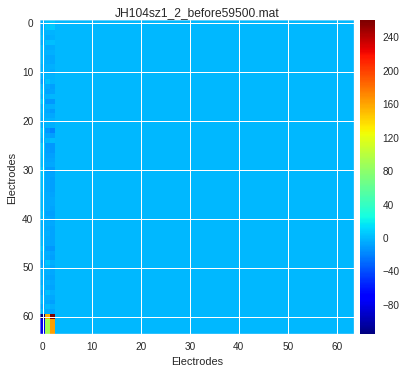

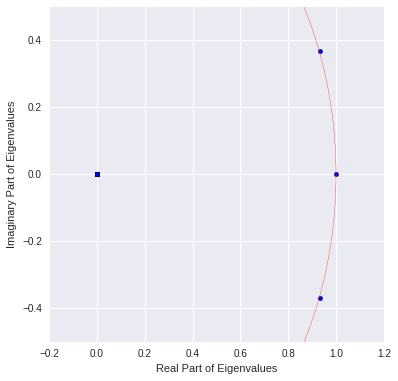

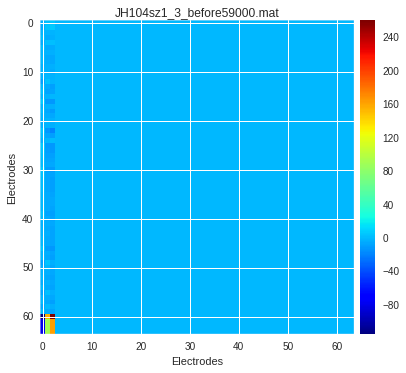

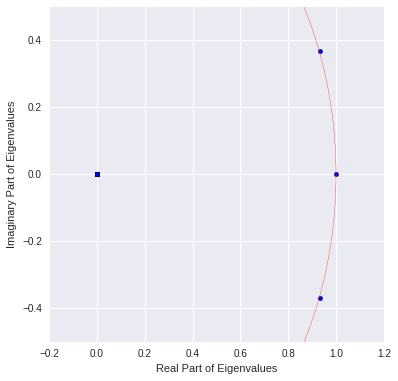

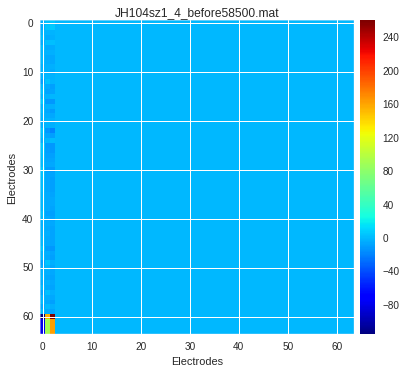

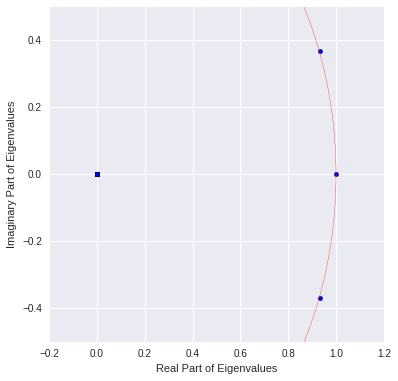

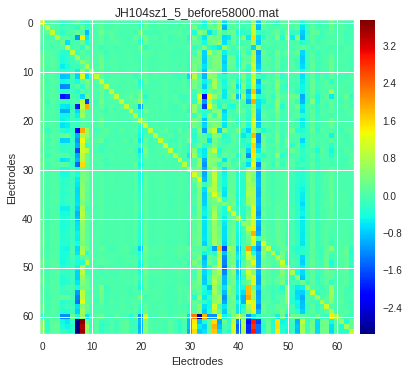

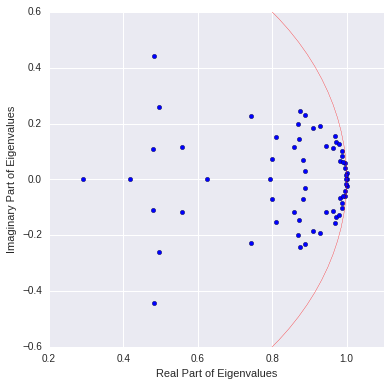

In [4]:
# plot all adjacency matrices
for file in filesInPeriod:
    fullfile = patientDir + file
    data = scipy.io.loadmat(fullfile, squeeze_me=True, struct_as_record=False)
    data = data['data']
    
    # extract the connectivity matrix and eigenspectrum
    theta_adj = data.theta_adj
    eig, v = np.linalg.eig(theta_adj)
    
    # plot heatmap of adj mat and eigenspectrum
    fig = plt.figure(figsize=(6,6))
    ax = plt.gca()
    im = plt.imshow(theta_adj, interpolation='none', cmap='jet')
    plt.xlabel('Electrodes')
    plt.ylabel('Electrodes')
    plt.title(str(file))
    vmin, vmax = plt.gci().get_clim()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.08)
    plt.colorbar(im, cax=cax)

    # plot eigenspectrum
    fig = plt.figure(figsize=(6,6))
    axes = plt.gca()
    plt.scatter(eig.real, eig.imag)
    circ = plt.Circle((0, 0), radius=1, edgecolor='r', facecolor='None')
    axes.add_patch(circ)
    plt.xlabel('Real Part of Eigenvalues')
    plt.ylabel('Imaginary Part of Eigenvalues')
#     break

plt.show()

## Discussion:
1) Need to add a rank check for all matlab code that generates the perturbations. If the adjacency matrix is not full rank, then you can't compute the perturbation.

## Right Before Seizure

This analyzes the:

* eigenspectrum
* adjacency mat right before seizure. 

Also looks at the perturbation necessary to destabilize the network here.

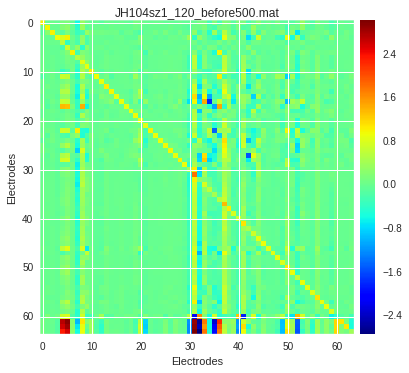

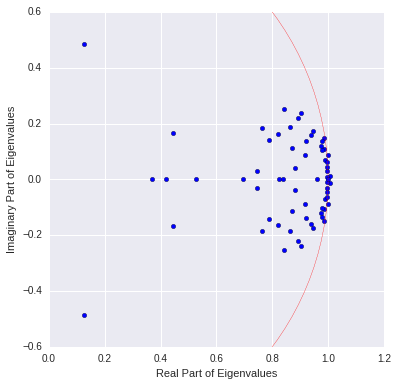

1.00525344753


In [5]:
## PLOTTING THE LAST FEW TIME POINTS
sortedMatfiles = natsorted(matFiles)

fullfile = patientDir + sortedMatfiles[len(matFiles)-1]
data = scipy.io.loadmat(fullfile, squeeze_me=True, struct_as_record=False)
data = data['data']

# extract the connectivity matrix and eigenspectrum
theta_adj = data.theta_adj
eig, v = np.linalg.eig(theta_adj)

# plot heatmap of adj mat and eigenspectrum
fig = plt.figure(figsize=(6,6))
ax = plt.gca()
im = plt.imshow(theta_adj, interpolation='none', cmap='jet')
plt.xlabel('Electrodes')
plt.ylabel('Electrodes')
plt.title(sortedMatfiles[len(matFiles)-1])
vmin, vmax = plt.gci().get_clim()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.08)
plt.colorbar(im, cax=cax)


fig = plt.figure(figsize=(6,6))
axes = plt.gca()
plt.scatter(eig.real, eig.imag)
plt.xlabel('Real Part of Eigenvalues')
plt.ylabel('Imaginary Part of Eigenvalues')
ymin,ymax = axes.get_ylim()
xmin,xmax = axes.get_xlim()
circ = plt.Circle((0, 0), radius=1, edgecolor='r', facecolor='None')
axes.add_patch(circ)

plt.show()


print max(np.abs(eig))

<a id="section2"></a>
### Section 2: Raw EEG Traces of Channels

Generally, it is good to compare to other channels to see if there is relatively some high frequency noise, or other factors causing differences in the fragility rankings.

In [10]:
# patients = ['JH104sz1', 'JH104sz2', 'JH104sz3']
patients = ['pt15sz2']
dataDir = '../data/'
# labels = ['POLLAT4']
labels = ['POLR3', 'POLPST3']
freq = 1000
offset = 10000 # how much to offset the plot by
PLOTOFFSET = 1.1
timeToPlot = 10 # how many seconds to plot?

def normalizeEEG(eeg):
    eeg = np.abs(eeg)
    normEEG = eeg / np.max(eeg)
    return normEEG

# loop through each patient and plot the raw eeg traces
for pat in patients:
    plotoffset = PLOTOFFSET # how much to move up each corresponding plot
    
    # create path to file for each different patient-seizure
    patFile = os.path.join(dataDir, pat, pat) 
    
    # load in the eeg and labels
    data = scipy.io.loadmat(patFile, squeeze_me=True, struct_as_record=False)
    eeg = data['data']
    elec_labels = data['elec_labels']
    
    # find indices of the labels
    indexoflabel = []
    for label in labels:
        elec_list = list(elec_labels)
        indexoflabel.append(elec_list.index(label))
    labelEEG = eeg[indexoflabel, :]
    
    # random eeg traces to compare to
    randomIndices = np.random.choice(len(elec_labels), 3)
    randomLabels = elec_labels[randomIndices]
    randomEEG = eeg[randomIndices, :]
        
    ## Plotting: eeg for that label and some random indices
    fig = plt.figure(figsize=(15,10))
    axes = plt.gca()
    normEEG = normalizeEEG(np.squeeze(labelEEG[:, offset:offset+freq*timeToPlot]))
    lab = labels[0]
    plt.plot(normEEG, label=lab)
    # plot the random electrodes as comparison
    for idx, iLabel in enumerate(randomLabels):
        normEEG = normalizeEEG(np.squeeze(randomEEG[idx, offset:offset+freq*timeToPlot])) + plotoffset
        plt.plot(normEEG, label=iLabel)
        plotoffset += PLOTOFFSET
    # plot parameters
    axes.legend()
    plt.yticks(np.arange(0.5, PLOTOFFSET*(len(randomLabels)+len(labels)), PLOTOFFSET), labels + map(str,randomLabels))
    plt.xlabel('time (seconds)')
    plt.ylabel('EEG mV activity')
    plt.ylim([-0.5, 0.5+PLOTOFFSET*(len(randomLabels)+len(labels))])
    plt.title(pat)
    plt.tight_layout()
plt.show()

ValueError: Image size of 1050x150081 pixels is too large. It must be less than 2^16 in each direction.

In [16]:
def determineClinicalAnnotations(patient_id):
    if patient_id == 'EZT005':
        included_channels = np.concatenate((np.arange(1,21+1), np.arange(23,60+1), np.arange(63,88+1)))
        ezone_labels = ['U4', 'U3', 'U5', 'U6', 'U8', 'U7'] 
        earlyspread_labels = []
        latespread_labels = []
    elif patient_id == 'EZT007':
        included_channels = np.concatenate((np.arange(1,16+1), np.arange(18,53+1), np.arange(55,71+1), \
                                           np.arange(74,78+1), np.arange(81,94+1)))
        ezone_labels = ['O7', 'E8', 'E7', 'I5', 'E9', 'I6', 'E3', 'E2',\
            'O4', 'O5', 'I8', 'I7', 'E10', 'E1', 'O6', 'I1', 'I9', 'E6',\
            'I4', 'O3', 'O2', 'I10', 'E4', 'Y1', 'O1', 'I3', 'I2'] 
        earlyspread_labels = []
        latespread_labels = []
    elif patient_id == 'EZT019':
        included_channels = np.concatenate((np.arange(1,5+1), np.arange(7,22+1), np.arange(24,79+1)))
        ezone_labels = ['I5', 'I6', 'B9', 'I9', 'T10', 'I10', 'B6', 'I4', \
            'T9', 'I7', 'B3', 'B5', 'B4', 'I8', 'T6', 'B10', 'T3',\
            'B1', 'T8', 'T7', 'B7', 'I3', 'B2', 'I2', 'T4', 'T2'] 
        earlyspread_labels = []
        latespread_labels = []
    elif patient_id == 'EZT045':
        included_channels = np.concatenate((np.arange(1,2), np.arange(3,14+1), np.arange(16,20+1), np.arange(24,38+1), \
                                           np.arange(30,65+1)))
        ezone_labels = ['X2', 'X1']
        earlyspread_labels = []
        latespread_labels = [] 
#     elif patient_id == 'EZT090':

    elif patient_id == 'pt1':
        included_channels = np.concatenate((np.arange(1,36+1), np.arange(42, 43+1), np.arange(46,69+1), np.arange(72,95+1)))
        ezone_labels = ['POLATT1', 'POLATT2', 'POLAD1', 'POLAD2', 'POLAD3']
        earlyspread_labels = ['POLATT3', 'POLAST1', 'POLAST2']
        latespread_labels = ['POLATT4', 'POLATT5', 'POLATT6', \
                            'POLSLT2', 'POLSLT3', 'POLSLT4', \
                            'POLMLT2', 'POLMLT3', 'POLMLT4', 'POLG8', 'POLG16']
    elif patient_id == 'pt15':
        included_channels = np.concatenate((np.arange(2,7+1), np.arange(9,30+1), np.arange(32,36+1), np.arange(41,42+1), \
                                           np.arange(45,69+1), np.arange(71, 86+1), np.arange(88, 89+1)))
        ezone_labels = []
        earlyspread_labels = []
        latespread_labels = [] 
    return included_channels, ezone_labels, earlyspread_labels, latespread_labels

# function to load in the electrode labels
def loadLabels(pat_id, patient, dataDir):
    # create path to file for each different patient-seizure
    patFile = os.path.join(dataDir, pat_id, patient+'.mat') 
    # load in the eeg and labels
    data = scipy.io.loadmat(patFile, squeeze_me=True, struct_as_record=False)
    elec_labels = data['elec_labels']
    
    return elec_labels

# function to load in the eeg
def loadEEG(pat_id, patient, dataDir):
    # create path to file for each different patient-seizure
    patFile = os.path.join(dataDir, pat_id, patient+'.mat') 
    # load in the eeg and labels
    data = scipy.io.loadmat(patFile, squeeze_me=True, struct_as_record=False)
    eeg = data['data']
    return eeg

def loadSeizureStart(pat_id, patient, dataDir):
    # create path to file for each different patient-seizure
    patFile = os.path.join(dataDir, pat_id, patient+'.mat') 
    # load in the eeg and labels
    data = scipy.io.loadmat(patFile, squeeze_me=True, struct_as_record=False)
    seizureStart = data['seiz_start_mark']
    
    return seizureStart

Patient id is:  pt15


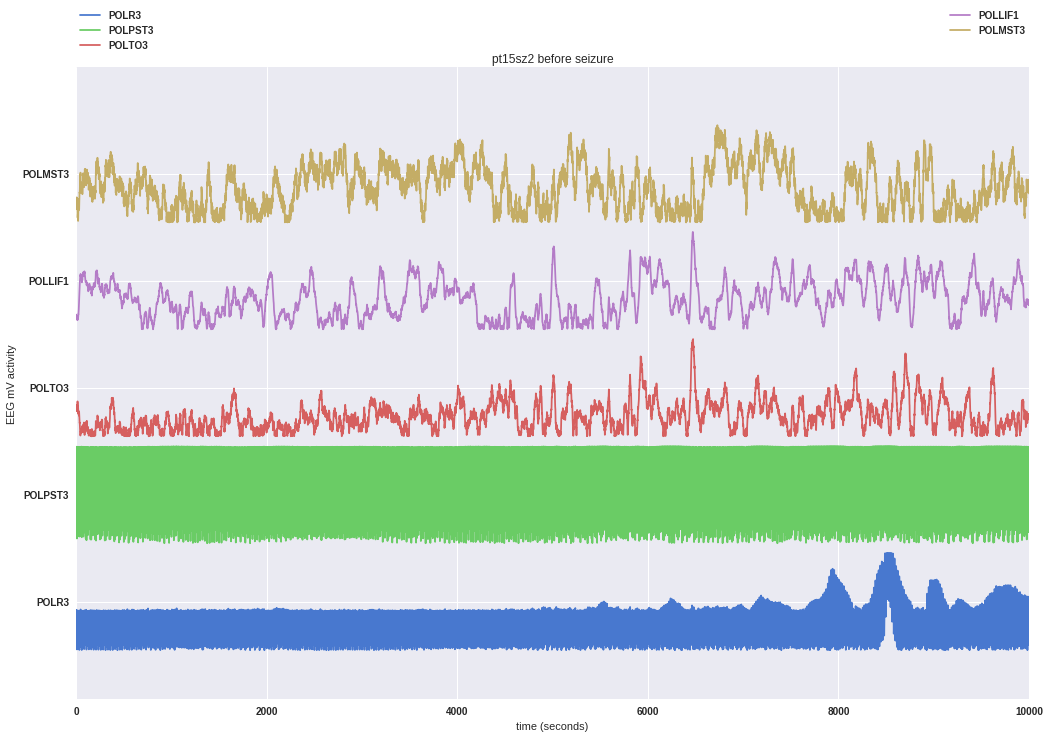

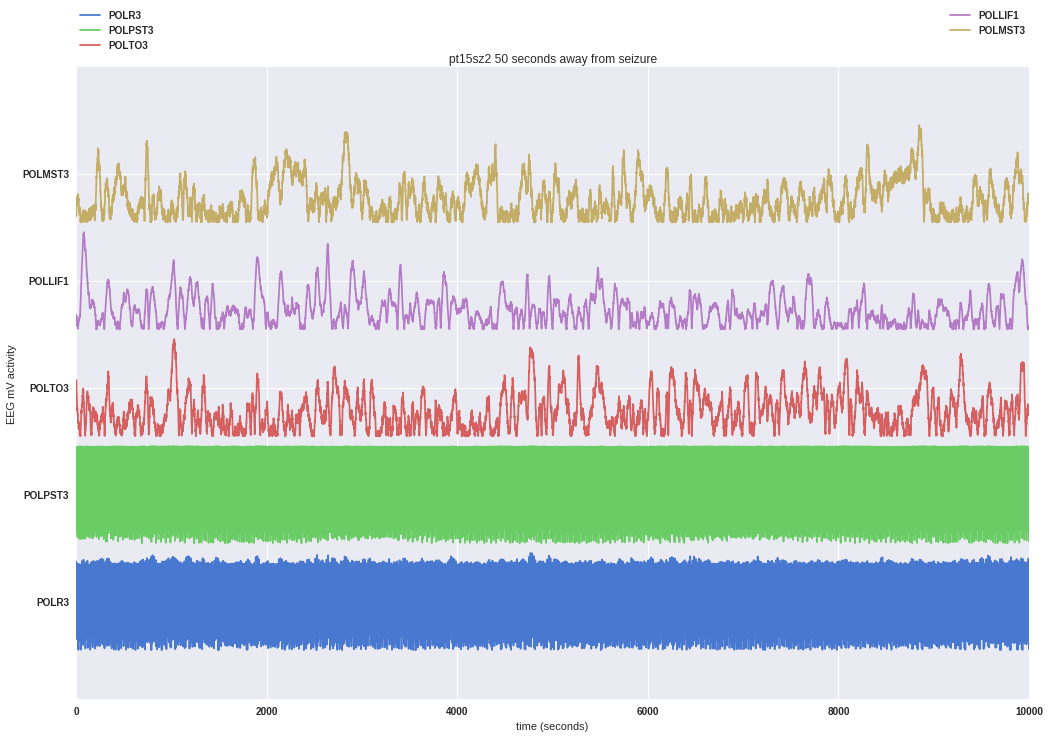

In [19]:
# patients = ['JH104sz1', 'JH104sz2', 'JH104sz3']
patients = ['pt15sz2']
dataDir = '../data/'
# labels = ['POLLAT4']
labels = ['POLR3', 'POLPST3']
freq = 1000
offset = 10000 # how much to offset the plot by
PLOTOFFSET = 1.1
timeToPlot = 10 # how many seconds to plot?

def normalizeEEG(eeg):
    eeg = np.abs(eeg)
    normEEG = eeg / np.max(eeg)
    return normEEG

# loop through each patient and plot the raw eeg traces
for patient in patients:
    ## 01: LOAD IN EEG, ELECTRODE LABELS AND INDICES
    # load in the includedchannels, ezlabels, earlyspread/latespread labels
    pat_id = patient.split('_seiz')[0]
    if pat_id==patient:
        pat_id = patient.split('sz')[0]
    print "Patient id is: ", pat_id
    included_channels, ezone_labels, earlyspread_labels, latespread_labels = determineClinicalAnnotations(pat_id)
    # load electrode labels of this patient
    elec_labels = loadLabels(patient, patient, dataDir) # loaded electrode labels
    seizureStart = loadSeizureStart(patient, patient, dataDir)
    eeg = loadEEG(patient, patient, dataDir) # loaded eeg
    elec_indices = np.arange(0, len(elec_labels))

    # find indices of the ez labels and the ones not in ez
    ezIndices = []
    for label in ezone_labels:
        elec_list = list(elec_labels)
        ezIndices.append(elec_list.index(label))
    otherIndices = np.asarray(filter(lambda x: x not in indexoflabel, elec_indices))
    # decrement all indices by 1 to start at 0
    ezIndices = np.asarray(ezIndices)
    otherIndices = otherIndices
    randomIndices = otherIndices[np.random.choice(len(otherIndices), 3)]
    
    # plot set labels in line 2
    ezIndices = []
    for label in labels:
        elec_list =list(elec_labels)
        ezIndices.append(elec_list.index(label))
    otherIndices = np.asarray(filter(lambda x: x not in indexoflabel, elec_indices))
    # decrement all indices by 1 to start at 0
    ezIndices = np.asarray(ezIndices)
    otherIndices = otherIndices
    randomIndices = otherIndices[np.random.choice(len(otherIndices), 3)]
    
    ## 02: CREATE THE EEG TRACES WE WANT TO PLOT
    # get eeg traces to compare to
    randomLabels = elec_labels[randomIndices]
    ezLabels = elec_labels[ezIndices]
    randomEEG = eeg[randomIndices, :]
    labelEEG = eeg[ezIndices,:]
    
    ## 03: PLOTTING THE EEG TRACES ON 1 SINGLE PLOT AND LABELING THE Y AXIS
    timeToPlot = [seizureStart-offset, seizureStart]
    plotoffset = 0 # how much to move up each corresponding plot
    
    # Plotting: eeg for that label and some random indices
    fig = plt.figure(figsize=(15,10))
    axes = plt.gca()
    plt.rc('font', size='20', weight='bold')
    for idx, lab in enumerate(ezLabels):
        normEEG = normalizeEEG(np.squeeze(labelEEG[idx, timeToPlot[0]:timeToPlot[1]])) + plotoffset
        plt.plot(normEEG, label=lab)
        plotoffset += PLOTOFFSET
    # plot the random electrodes as comparison
    for idx, iLabel in enumerate(randomLabels):
        normEEG = normalizeEEG(np.squeeze(randomEEG[idx, timeToPlot[0]:timeToPlot[1]])) + plotoffset
        plt.plot(normEEG, label=iLabel)
        plotoffset += PLOTOFFSET
    # plot parameters
    axes.legend(bbox_to_anchor=(0., 1.02, 1., .102),loc=3,
           ncol=2,  mode="expand",borderaxespad=0.)
    plt.yticks(np.arange(0.5, PLOTOFFSET*(len(randomLabels)+len(ezLabels)), PLOTOFFSET), map(str,ezLabels) + map(str,randomLabels))
    plt.xlabel('time (seconds)')
    plt.ylabel('EEG mV activity')
    plt.ylim([-0.5, 0.5+PLOTOFFSET*(len(randomLabels)+len(ezLabels))])
    plt.title(patient + ' before seizure')
    plt.tight_layout()
    
    timeToPlot = [offset, offset*2]
    plotoffset = 0 # how much to move up each corresponding plot
    # Plotting: eeg for that label and some random indices
    fig = plt.figure(figsize=(15,10))
    axes = plt.gca()
    plt.rc('font', size='20', weight='bold')
    for idx, lab in enumerate(ezLabels):
        normEEG = normalizeEEG(np.squeeze(labelEEG[idx, timeToPlot[0]:timeToPlot[1]])) + plotoffset
        plt.plot(normEEG, label=lab)
        plotoffset += PLOTOFFSET
    # plot the random electrodes as comparison
    for idx, iLabel in enumerate(randomLabels):
        normEEG = normalizeEEG(np.squeeze(randomEEG[idx, timeToPlot[0]:timeToPlot[1]])) + plotoffset
        plt.plot(normEEG, label=iLabel)
        plotoffset += PLOTOFFSET
    # plot parameters
    axes.legend(bbox_to_anchor=(0., 1.02, 1., .102),loc=3,
           ncol=2,  mode="expand",borderaxespad=0.)
    plt.yticks(np.arange(0.5, PLOTOFFSET*(len(randomLabels)+len(ezLabels)), PLOTOFFSET), map(str,ezLabels) + map(str,randomLabels))
    plt.xlabel('time (seconds)')
    plt.ylabel('EEG mV activity')
    plt.ylim([-0.5, 0.5+PLOTOFFSET*(len(randomLabels)+len(ezLabels))])
    plt.title(patient + ' 50 seconds away from seizure')
    plt.tight_layout()
#     break
plt.show()

#### Discussion:
1) Note the high frequency noises present in LAT4, only in seizure 2 and 3. This accounts for the very low fragility ranking (?) in row perturbation.

<a id="section3"></a>
## Section 3: Plotting SEEG Traces

The following eeg vs. time plots show the EZ electrode activity vs. 3 other random electrode activities. The time that we plot is the time right before seizure by 10 seconds.

In [7]:
def determineClinicalAnnotations(patient_id):
    if patient_id == 'EZT005':
        included_channels = np.concatenate((np.arange(1,21+1), np.arange(23,60+1), np.arange(63,88+1)))
        ezone_labels = ['U4', 'U3', 'U5', 'U6', 'U8', 'U7'] 
        earlyspread_labels = []
        latespread_labels = []
    elif patient_id == 'EZT007':
        included_channels = np.concatenate((np.arange(1,16+1), np.arange(18,53+1), np.arange(55,71+1), \
                                           np.arange(74,78+1), np.arange(81,94+1)))
        ezone_labels = ['O7', 'E8', 'E7', 'I5', 'E9', 'I6', 'E3', 'E2',\
            'O4', 'O5', 'I8', 'I7', 'E10', 'E1', 'O6', 'I1', 'I9', 'E6',\
            'I4', 'O3', 'O2', 'I10', 'E4', 'Y1', 'O1', 'I3', 'I2'] 
        earlyspread_labels = []
        latespread_labels = []
    elif patient_id == 'EZT019':
        included_channels = np.concatenate((np.arange(1,5+1), np.arange(7,22+1), np.arange(24,79+1)))
        ezone_labels = ['I5', 'I6', 'B9', 'I9', 'T10', 'I10', 'B6', 'I4', \
            'T9', 'I7', 'B3', 'B5', 'B4', 'I8', 'T6', 'B10', 'T3',\
            'B1', 'T8', 'T7', 'B7', 'I3', 'B2', 'I2', 'T4', 'T2'] 
        earlyspread_labels = []
        latespread_labels = []
    elif patient_id == 'EZT045':
        included_channels = np.concatenate((np.arange(1,2), np.arange(3,14+1), np.arange(16,20+1), np.arange(24,38+1), \
                                           np.arange(30,65+1)))
        ezone_labels = ['X2', 'X1']
        earlyspread_labels = []
        latespread_labels = [] 
#     elif patient_id == 'EZT090':

    elif patient_id == 'pt1':
        included_channels = np.concatenate((np.arange(1,36+1), np.arange(42, 43+1), np.arange(46,69+1), np.arange(72,95+1)))
        ezone_labels = ['POLATT1', 'POLATT2', 'POLAD1', 'POLAD2', 'POLAD3']
        earlyspread_labels = ['POLATT3', 'POLAST1', 'POLAST2']
        latespread_labels = ['POLATT4', 'POLATT5', 'POLATT6', \
                            'POLSLT2', 'POLSLT3', 'POLSLT4', \
                            'POLMLT2', 'POLMLT3', 'POLMLT4', 'POLG8', 'POLG16']
    elif patient_id == 'pt15':
        included_channels = np.concatenate((np.arange(2,7+1), np.arange(9,30+1), np.arange(32,36+1), np.arange(41,42+1), \
                                           np.arange(45,69+1), np.arange(71, 86+1), np.arange(88, 89+1)))
        ezone_labels = []
        earlyspread_labels = []
        latespread_labels = [] 
    return included_channels, ezone_labels, earlyspread_labels, latespread_labels

# function to load in the electrode labels
def loadLabels(pat_id, patient, dataDir):
    # create path to file for each different patient-seizure
    patFile = os.path.join(dataDir, pat_id, patient+'.mat') 
    # load in the eeg and labels
    data = scipy.io.loadmat(patFile, squeeze_me=True, struct_as_record=False)
    elec_labels = data['elec_labels']
    
    return elec_labels

# function to load in the eeg
def loadEEG(pat_id, patient, dataDir):
    # create path to file for each different patient-seizure
    patFile = os.path.join(dataDir, pat_id, patient+'.mat') 
    # load in the eeg and labels
    data = scipy.io.loadmat(patFile, squeeze_me=True, struct_as_record=False)
    eeg = data['data']
    return eeg

def loadSeizureStart(pat_id, patient, dataDir):
    # create path to file for each different patient-seizure
    patFile = os.path.join(dataDir, pat_id, patient+'.mat') 
    # load in the eeg and labels
    data = scipy.io.loadmat(patFile, squeeze_me=True, struct_as_record=False)
    seizureStart = data['seiz_start_mark']
    
    return seizureStart

Patient id is:  EZT005
Patient id is:  EZT005


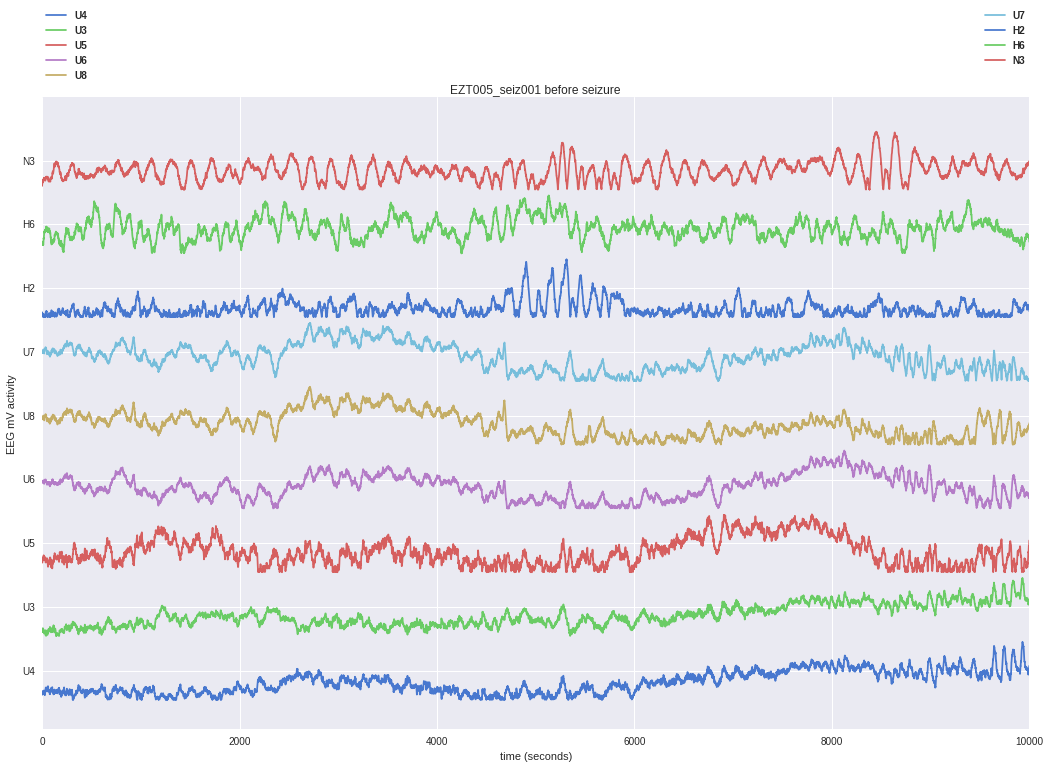

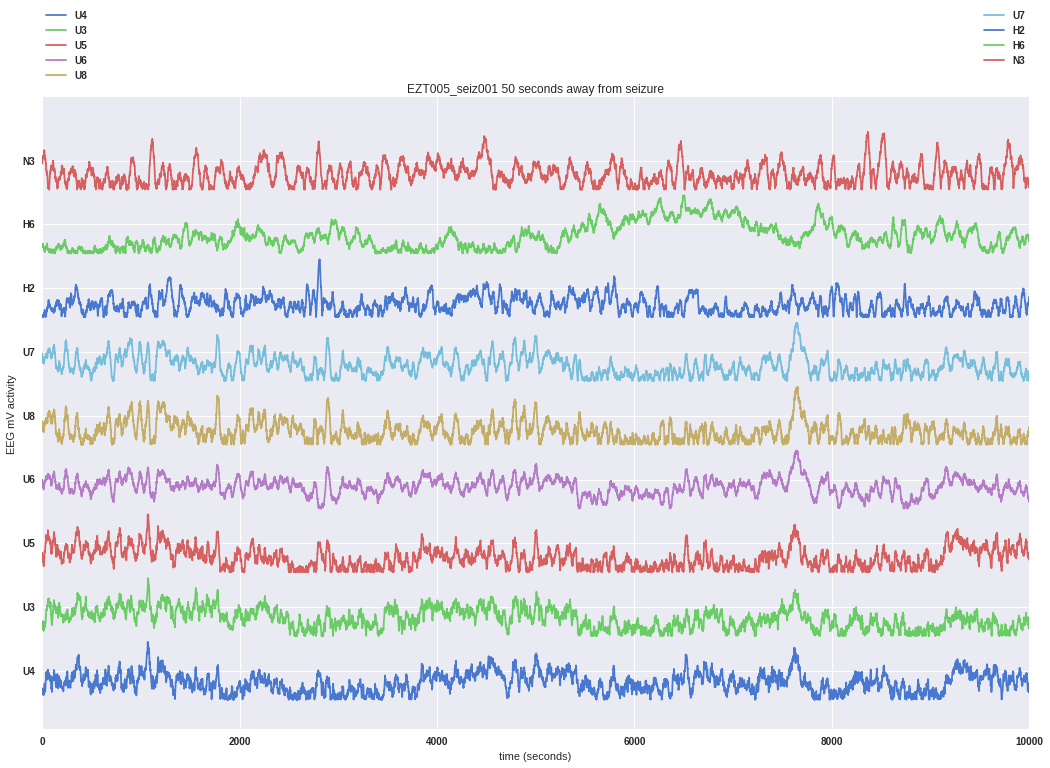

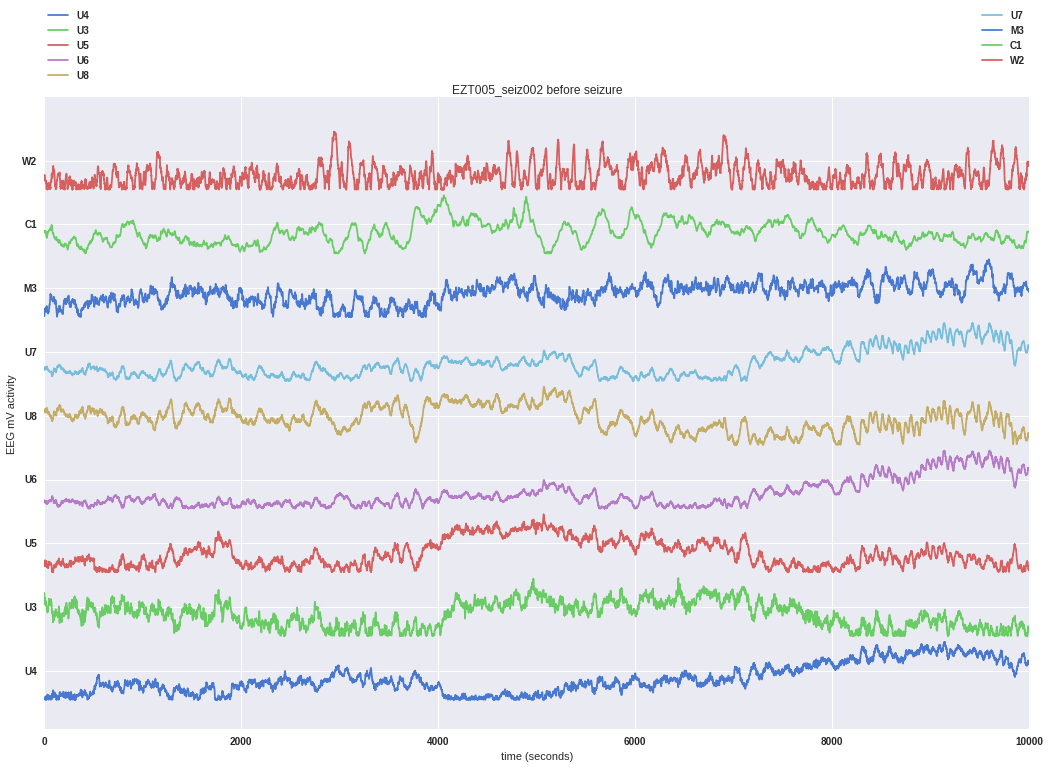

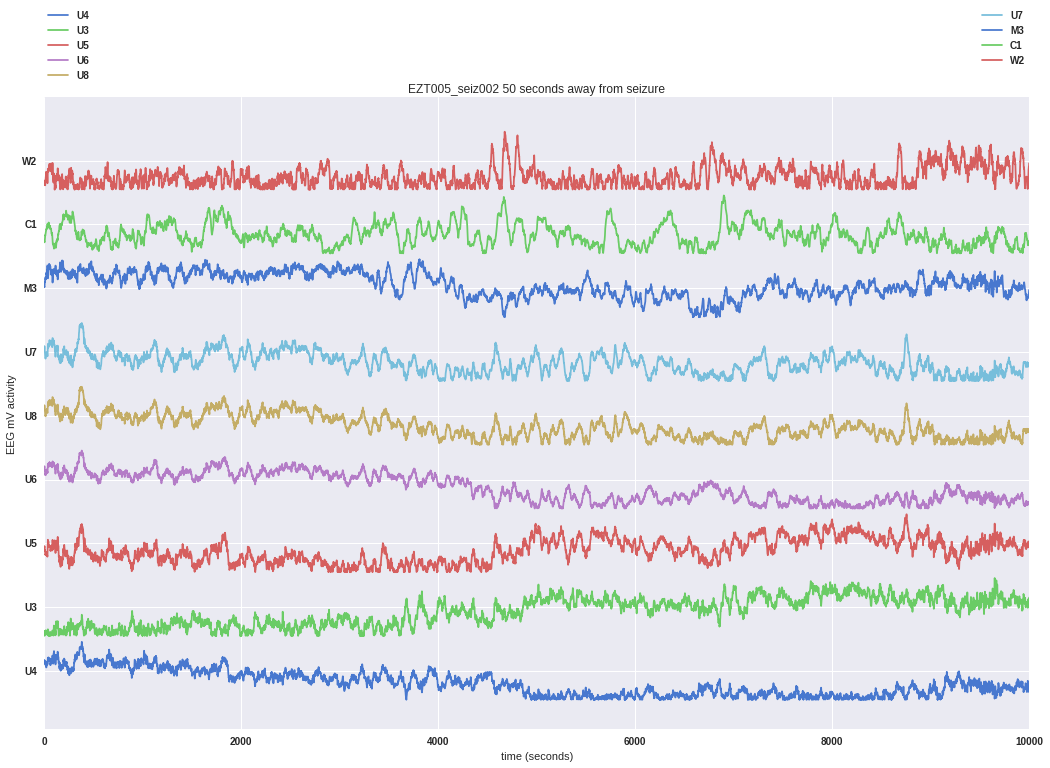

In [8]:
patients = ['EZT005_seiz001', 'EZT005_seiz002']
dataDir = '../data/Seiz_Data/'
freq = 1000
offset = 10000 # how much to offset the plot by
PLOTOFFSET = 1.1
timeToPlot = 10 # how many seconds to plot?


# loop through each patient and plot the raw eeg traces
for patient in patients:
    ## 01: LOAD IN EEG, ELECTRODE LABELS AND INDICES
    # load in the includedchannels, ezlabels, earlyspread/latespread labels
    pat_id = patient.split('_seiz')[0]
    if pat_id==patient:
        pat_id = patient.split('sz')[0]
    print "Patient id is: ", pat_id
    included_channels, ezone_labels, earlyspread_labels, latespread_labels = determineClinicalAnnotations(pat_id)
    # load electrode labels of this patient
    elec_labels = loadLabels(pat_id, patient, dataDir) # loaded electrode labels
    seizureStart = loadSeizureStart(pat_id, patient, dataDir)
    eeg = loadEEG(pat_id, patient, dataDir) # loaded eeg
    elec_indices = np.arange(0, len(elec_labels))

    # find indices of the ez labels and the ones not in ez
    ezIndices = []
    for label in ezone_labels:
        elec_list = list(elec_labels)
        ezIndices.append(elec_list.index(label))
    otherIndices = np.asarray(filter(lambda x: x not in indexoflabel, elec_indices))
    # decrement all indices by 1 to start at 0
    ezIndices = np.asarray(ezIndices)
    otherIndices = otherIndices
    randomIndices = otherIndices[np.random.choice(len(otherIndices), 3)]
    
    ## 02: CREATE THE EEG TRACES WE WANT TO PLOT
    # get eeg traces to compare to
    randomLabels = elec_labels[randomIndices]
    ezLabels = elec_labels[ezIndices]
    randomEEG = eeg[randomIndices, :]
    labelEEG = eeg[ezIndices,:]
    
    ## 03: PLOTTING THE EEG TRACES ON 1 SINGLE PLOT AND LABELING THE Y AXIS
    timeToPlot = [seizureStart-offset, seizureStart]
    plotoffset = 0 # how much to move up each corresponding plot
    
    # Plotting: eeg for that label and some random indices
    fig = plt.figure(figsize=(15,10))
    axes = plt.gca()
    plt.rc('font', size='20', weight='bold')
    for idx, lab in enumerate(ezLabels):
        normEEG = normalizeEEG(np.squeeze(labelEEG[idx, timeToPlot[0]:timeToPlot[1]])) + plotoffset
        plt.plot(normEEG, label=lab)
        plotoffset += PLOTOFFSET
    # plot the random electrodes as comparison
    for idx, iLabel in enumerate(randomLabels):
        normEEG = normalizeEEG(np.squeeze(randomEEG[idx, timeToPlot[0]:timeToPlot[1]])) + plotoffset
        plt.plot(normEEG, label=iLabel)
        plotoffset += PLOTOFFSET
    # plot parameters
    axes.legend(bbox_to_anchor=(0., 1.02, 1., .102),loc=3,
           ncol=2,  mode="expand",borderaxespad=0.)
    plt.yticks(np.arange(0.5, PLOTOFFSET*(len(randomLabels)+len(ezLabels)), PLOTOFFSET), map(str,ezLabels) + map(str,randomLabels))
    plt.xlabel('time (seconds)')
    plt.ylabel('EEG mV activity')
    plt.ylim([-0.5, 0.5+PLOTOFFSET*(len(randomLabels)+len(ezLabels))])
    plt.title(patient + ' before seizure')
    plt.tight_layout()
    
    timeToPlot = [offset, offset*2]
    plotoffset = 0 # how much to move up each corresponding plot
    # Plotting: eeg for that label and some random indices
    fig = plt.figure(figsize=(15,10))
    axes = plt.gca()
    plt.rc('font', size='20', weight='bold')
    for idx, lab in enumerate(ezLabels):
        normEEG = normalizeEEG(np.squeeze(labelEEG[idx, timeToPlot[0]:timeToPlot[1]])) + plotoffset
        plt.plot(normEEG, label=lab)
        plotoffset += PLOTOFFSET
    # plot the random electrodes as comparison
    for idx, iLabel in enumerate(randomLabels):
        normEEG = normalizeEEG(np.squeeze(randomEEG[idx, timeToPlot[0]:timeToPlot[1]])) + plotoffset
        plt.plot(normEEG, label=iLabel)
        plotoffset += PLOTOFFSET
    # plot parameters
    axes.legend(bbox_to_anchor=(0., 1.02, 1., .102),loc=3,
           ncol=2,  mode="expand",borderaxespad=0.)
    plt.yticks(np.arange(0.5, PLOTOFFSET*(len(randomLabels)+len(ezLabels)), PLOTOFFSET), map(str,ezLabels) + map(str,randomLabels))
    plt.xlabel('time (seconds)')
    plt.ylabel('EEG mV activity')
    plt.ylim([-0.5, 0.5+PLOTOFFSET*(len(randomLabels)+len(ezLabels))])
    plt.title(patient + ' 50 seconds away from seizure')
    plt.tight_layout()
#     break
plt.show()

In [9]:
map(str,ezLabels) + map(str,randomLabels)

['U4', 'U3', 'U5', 'U6', 'U8', 'U7', 'M3', 'C1', 'W2']